#**performing hyperparamter tunning to determine the learning rate no. of hidden neurons and layers.**

#Importing librarires

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

#Importing the Dataset

In [3]:
df = pd.read_csv('/content/Churn_Modelling (1).csv')
X = df.iloc[:, 3:13]
y = df.iloc[:, 13]


# Data Preprocessing

In [4]:
# Create dummy variables
geography = pd.get_dummies(X["Geography"], drop_first=True)
gender = pd.get_dummies(X['Gender'], drop_first=True)

In [5]:
# Concatenate the Data Frames
X = pd.concat([X, geography, gender], axis=1)
X = X.drop(['Geography', 'Gender'], axis=1)

# Split the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Feature Scaling

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Basic ANN Model without hyperparamter tuning

In [8]:
#ann = tf.keras.models.Sequential()
#ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

# Model with hyperparameter tunning

# **Model Building**

In [9]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Tuning the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=6, max_value=128, step=6),
            activation='relu'
        ))
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1,kernel_initializer= 'glorot_uniform', activation='sigmoid'))

    # Tuning the learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# Defining Tuner

In [10]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='tuners_results',
    project_name='Hyperpara'
)

# Fit the tuner

In [11]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 254 Complete [00h 01m 22s]
val_accuracy: 0.8637499809265137

Best val_accuracy So Far: 0.871874988079071
Total elapsed time: 00h 59m 19s


 # Best hyperparameters and the best score

In [12]:
best_score = tuner.get_best_models(num_models=1)[0].evaluate(X_test, y_test, verbose=0)[0]
print(f"Best learning rate: {best_hyperparameters.get('learning_rate')}")
print(f"Number of layers: {best_hyperparameters.get('num_layers')}")
print(f"Units in layers: {[best_hyperparameters.get(f'units_{i}') for i in range(best_hyperparameters.get('num_layers'))]}")
print(f"Best score (loss on test set): {best_score}")

Best learning rate: 0.001
Number of layers: 3
Units in layers: [120, 24, 114]
Best score (loss on test set): 0.33724477887153625


#Training best model

In [13]:
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7913 - loss: 0.5054 - val_accuracy: 0.8069 - val_loss: 0.4334
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8028 - loss: 0.4426 - val_accuracy: 0.8244 - val_loss: 0.4155
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8205 - loss: 0.4287 - val_accuracy: 0.8325 - val_loss: 0.3920
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8286 - loss: 0.4012 - val_accuracy: 0.8456 - val_loss: 0.3718
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8375 - loss: 0.3821 - val_accuracy: 0.8556 - val_loss: 0.3602
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8453 - loss: 0.3649 - val_accuracy: 0.8562 - val_loss: 0.3584
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8543 - loss: 0.3601 - val_accuracy: 0.8500 - val_loss: 0.3597
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8636 - loss: 0.3516 - val_accu

In [15]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (32, 120)                   │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 120)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 24)                    │           2,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (32, 24)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 114)                   │           2,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (32, 114)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 1)                     │             115 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,929 (85.66 KB)

 Trainable params: 7,309 (28.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,620 (57.11 KB)

# Making confusion matrix

In [16]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#Model Evaluation

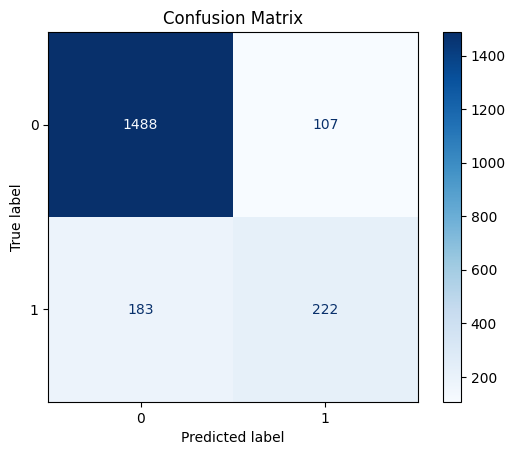

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [17]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8529 - loss: 0.3380
Test Accuracy: 0.8550000190734863
